In [351]:
# CLAIM: Model is robust to sequence extension and truncation. 

In [352]:
import pandas as pd 
from utils import * 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [378]:
dataset_path = '../data/results/results-2/dataset.csv'
top_hit_predictions_path = '../data/results/results-2/top_hits_predict.csv'
predictions_path = '../data/results/results-2/dataset_predict.csv'

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 

results_df = load_results(dataset_path=dataset_path, top_hit_predictions_path=top_hit_predictions_path, predictions_path=predictions_path, exclude_genome_ids=exclude_genome_ids)
results_df = results_df[results_df.match].copy() # Filtering for the matches.
results_df = results_df[~results_df.top_hit_ribosomal_slippage].copy() # Not considering instances of ribosomal slippage (programmed frameshifts), as it complicates analysis and there are only 8. 

In [379]:
# Adjust the start and stop coordinates to consist only of the coding region. 
results_df['top_hit_codon_start'] = results_df.top_hit_codon_start.astype(int) - 1
results_df['top_hit_start'] = np.where(results_df.top_hit_strand == 1, results_df.top_hit_start + results_df.top_hit_codon_start, results_df.top_hit_start)
results_df['top_hit_stop'] = np.where(results_df.top_hit_strand == -1, results_df.top_hit_stop - results_df.top_hit_codon_start, results_df.top_hit_stop)
for prefix in ['query', 'top_hit']:
    lengths = results_df[f'{prefix}_stop'] - results_df[f'{prefix}_start'] + 1 # Get sequence lengths in nucleotides.
    results_df[f'{prefix}_stop'] = np.where(results_df[f'{prefix}_strand'] == 1, results_df[f'{prefix}_stop'] - (lengths % 3), results_df[f'{prefix}_stop'])
    results_df[f'{prefix}_start'] = np.where(results_df[f'{prefix}_strand'] == -1, results_df[f'{prefix}_start'] + (lengths % 3), results_df[f'{prefix}_start'])
assert np.all(((results_df.top_hit_stop - results_df.top_hit_start + 1) % 3) == 0)

is_five_prime_extension = lambda df : ((df.query_strand == 1) & (df.query_start < df.top_hit_start)) | ((df.query_strand == -1) & (df.query_stop > df.top_hit_stop))
is_five_prime_truncation = lambda df : ((df.query_strand == 1) & (df.query_start > df.top_hit_start)) | ((df.query_strand == -1) & (df.query_stop < df.top_hit_stop))
is_three_prime_extension = lambda df : ((df.query_strand == -1) & (df.query_start < df.top_hit_start)) | ((df.query_strand == 1) & (df.query_stop > df.top_hit_stop))
is_three_prime_truncation = lambda df : ((df.query_strand == -1) & (df.query_start > df.top_hit_start)) | ((df.query_strand == 1) & (df.query_stop < df.top_hit_stop))

results_df['three_prime_extension'] = is_three_prime_extension(results_df)
results_df['five_prime_extension'] = is_five_prime_extension(results_df)
results_df['three_prime_truncation'] = is_three_prime_truncation(results_df)
results_df['five_prime_truncation'] = is_five_prime_truncation(results_df)
results_df['extension'] = results_df.three_prime_extension | results_df.five_prime_extension
results_df['truncation'] = results_df.three_prime_truncation | results_df.five_prime_truncation
results_df['nt_length'] = (results_df.top_hit_stop - results_df.top_hit_start + 1) # Length of the reference sequence in nucleotides.
results_df['nt_length_diff'] = (results_df.query_stop - results_df.query_start) - (results_df.top_hit_stop - results_df.top_hit_start)
results_df['fraction_length_diff'] = (results_df.nt_length + results_df.nt_length_diff) / results_df.nt_length
results_df['model_output_1_diff'] = results_df.model_output_1 - results_df.top_hit_model_output_1 # Positive if the Prodigal sequence is more likely to be real, negative if less likely to be real. 
results_df['boundary_difference'] = results_df.extension | results_df.truncation
results_df['confirmed_coordinates'] = results_df.top_hit_evidence_type == 'similar to AA sequence'

# There are some cases where the start and stops align, but the Prodigal prediction has unknown amino acids. Will keep these in a seperate category.
# assert np.all(results_df.exact_match ^ (results_df.extension | results_df.truncation)), 'None of the exact matches should be marked as extended or truncated.'

# There are only 7 cases of both 3' and 5' errors, so just excluding these for now.
# assert ((results_df.three_prime_extension | results_df.three_prime_truncation) & (results_df.five_prime_extension | results_df.five_prime_truncation)).sum() == 0, "There are some cases of both 5' and 3'-terminal errors."
results_df = results_df[~((results_df.three_prime_extension | results_df.three_prime_truncation) & (results_df.five_prime_extension | results_df.five_prime_truncation))].copy()


In [ ]:
# In analyzing gene boundary differences, we must also address the fallibility of the reference annotation. The coordinates of ~50% of all matched reference ORFs are determined by homology 
# to a known gene; we consider these coordinates “confirmed,” as conservation provides support for the selected boundaries. However, the coordinates of the remaining ORFs are determined by
# GeneMarkS-2, an ab initio tool which is also subject to boundary selection errors [CITE]. We observe that the method of gene boundary selection has a significant effect on the likelihood 
# of gene boundary difference (p < 1e-53), suggesting that the observed 11% rate of Prodigal boundary errors may be artificially-inflated by GeneMarkS-2 errors; indeed, if we limit analysis 
# to ORFs with confirmed reference coordinates, error rate decreases to 9%. However, because the relative accuracy of different ab initio tools is highly-dependent on genome features, it is
# difficult to determine which boundary differences are genuine Prodigal errors [CITE]. 


n_boundary_differences = results_df.boundary_difference.sum()

# What fraction of all top hits have gene boundaries determined by GeneMark?
# As per PGAP papers, the coordinated of ORFs detected by protein motif also have boundaries determined by GeneMark.
print('Num. ORFs with confirmed reference coordinates:', results_df.confirmed_coordinates.sum(), f'({get_percent(results_df.confirmed_coordinates.sum(), len(results_df))})')

print('Num. ORFs with boundary differences and GeneMarkS-2 reference coordinates:', (results_df.boundary_difference & ~has_confirmed_coords(results_df)).sum(), f'({get_percent((results_df.boundary_difference & ~has_confirmed_coords(results_df)).sum(), n_boundary_differences)})')
print('Num. ORFs with boundary differences and confirmed reference coordinates:', (results_df.boundary_difference & has_confirmed_coords(results_df)).sum(), f'({get_percent((results_df.boundary_difference & has_confirmed_coords(results_df)).sum(), n_boundary_differences)})')

p = get_chi_square_p_value(pd.crosstab(results_df.confirmed_coordinates, results_df.boundary_difference))
print(f'p = {p:.3e}')


Num. ORFs with confirmed reference coordinates: 24204 (49.00%)
Num. ORFs with boundary differences and GeneMarkS-2 reference coordinates: 3330 (61.10%)
Num. ORFs with boundary differences and confirmed reference coordinates: 2120 (38.90%)
p = 5.497e-54


In [ ]:
def print_boundary_difference_info(results_df:pd.DataFrame, confirmed_only:bool=False):

    if confirmed_only:
        results_df = results_df[results_df.top_hit_evidence_type == 'similar to AA sequence'].copy()

    total = results_df.boundary_difference.sum()
    print('print_boundary_difference_info: Num. boundary errors:', total, f'({get_percent(total, len(results_df))})')

    print("print_boundary_difference_info: Num. 5' extensions:", results_df.five_prime_extension.sum(), f'({get_percent(results_df.five_prime_extension.sum(), total)})')
    print("print_boundary_difference_info: Num. 3' extensions:", results_df.three_prime_extension.sum(), f'({get_percent(results_df.three_prime_extension.sum(), total)})')
    print("print_boundary_difference_info: Num. 5' truncations:", results_df.five_prime_truncation.sum(), f'({get_percent(results_df.five_prime_truncation.sum(), total)})')
    print("print_boundary_difference_info: Num. 3' truncations:", results_df.three_prime_truncation.sum(), f'({get_percent(results_df.three_prime_truncation.sum(), total)})', end='\n\n')

# Possible that the error rate is being overestimated due to GeneMarkS-2 boundary errors, though it is difficult to be sure. 
print_boundary_difference_info(results_df)
print_boundary_difference_info(results_df, confirmed_only=True)

print_boundary_difference_info: Num. boundary errors: 5450 (11.03%)
print_boundary_difference_info: Num. 5' extensions: 3202 (58.75%)
print_boundary_difference_info: Num. 3' extensions: 55 (1.01%)
print_boundary_difference_info: Num. 5' truncations: 2179 (39.98%)
print_boundary_difference_info: Num. 3' truncations: 14 (0.26%)

print_boundary_difference_info: Num. boundary errors: 2120 (8.76%)
print_boundary_difference_info: Num. 5' extensions: 1297 (61.18%)
print_boundary_difference_info: Num. 3' extensions: 15 (0.71%)
print_boundary_difference_info: Num. 5' truncations: 801 (37.78%)
print_boundary_difference_info: Num. 3' truncations: 7 (0.33%)



In [ ]:
is_diff_model_label = lambda df : (df.model_label != df.top_hit_model_label) # & (results_df.nt_length_diff != 0)

print('Num. hypothetical:', is_top_hit_hypothetical(results_df).sum(), f'({get_percent(is_top_hit_hypothetical(results_df).sum(), len(results_df))})')
print('Num. hypothetical with boundary errors:', (is_top_hit_hypothetical(results_df) & (results_df.nt_length_diff != 0)).sum(), f'({get_percent((is_top_hit_hypothetical(results_df) & (results_df.nt_length_diff != 0)).sum(), n_boundary_differences)})')
print('Num. hypothetical with different model label:', (is_top_hit_hypothetical(results_df) & is_diff_model_label(results_df)).sum(), f'({get_percent((is_top_hit_hypothetical(results_df) & is_diff_model_label(results_df)).sum(), is_diff_model_label(results_df).sum())})')

# Seems as though hypothetical proteins are more sensitive to boundary errors, although this could possibly be due to the fact that hypothetical proteins are 
# generally shorter, and therefore smaller boundary errors have larger effects on the embedding.

Num. hypothetical: 7855 (15.90%)
Num. hypothetical with boundary errors: 1020 (18.72%)
Num. hypothetical with different model label: 62 (68.89%)


In [385]:
error_types = ['five_prime_extension', 'three_prime_extension', 'five_prime_truncation', 'three_prime_truncation', 'other']
conditions = [results_df[error_type] for error_type in error_types[:4]] + [((~results_df.exact_match) & (results_df.nt_length_diff == 0))]
results_df['error_type'] = np.select(conditions, error_types, default='none')

def table(results_df:pd.DataFrame, confirmed_only:bool=False):
    if confirmed_only:
        results_df = results_df[results_df.top_hit_evidence_type == 'similar to AA sequence'].copy()

    # results_df['nt_length_diff'] = np.abs(results_df.nt_length_diff)
    # results_df['length_diff_fraction'] = results_df.nt_length_diff / results_df.nt_length
    # results_df = results_df[results_df.length_diff_fraction < 0.2]

    table_df = pd.DataFrame(index=pd.Series(results_df.error_type.unique(), name='error_type'))
    table_df['total'] = results_df.groupby('error_type').size()
    table_df['different_model_label'] = results_df[results_df.model_label != results_df.top_hit_model_label].groupby('error_type').size()
    table_df['different_model_label_towards_spurious'] = results_df[(results_df.model_label != results_df.top_hit_model_label) & (results_df.model_output_1_diff < 0)].groupby('error_type').size()
    table_df['different_model_label_towards_real'] = results_df[(results_df.model_label != results_df.top_hit_model_label) & (results_df.model_output_1_diff > 0)].groupby('error_type').size()
    table_df = table_df.fillna(0)

    table_df['different_model_label_towards_spurious'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.different_model_label_towards_spurious, table_df['different_model_label'])]
    table_df['different_model_label_towards_real'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.different_model_label_towards_real, table_df['different_model_label'])]
    table_df['different_model_label'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.different_model_label, table_df['total'])]
    table_df = table_df[~table_df.index.isin(['none', 'other'])]

    return table_df

table(results_df, confirmed_only=True)



,total,different_model_label,different_model_label_towards_spurious,different_model_label_towards_real
error_type,,,,
five_prime_extension,1297,12.0 (0.93%),10.0 (83.33%),2.0 (16.67%)
five_prime_truncation,801,1.0 (0.12%),0.0 (0.00%),1.0 (100.00%)
three_prime_extension,15,1.0 (6.67%),1.0 (100.00%),0.0 (0.00%)
three_prime_truncation,7,0.0 (0.00%),0.0 (0%),0.0 (0%)


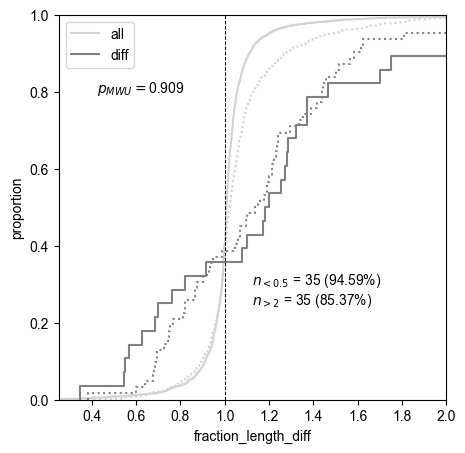

In [367]:
# Want to look into the boundary lengths which cause a label difference. Because it seems as though hypothetical proteins are more sensitive to boundary 
# adjustments, should separate by hypothetical proteins. 
def figure(results_df:pd.DataFrame):

    figure_df = results_df[results_df.nt_length_diff != 0].copy()

    model_label_diff = figure_df.top_hit_model_label != figure_df.model_label # Whether or not the model label changes.

    figure_df['nt_length'] = (figure_df.top_hit_stop - figure_df.top_hit_start)
    figure_df['fraction_length_diff'] = (figure_df.nt_length + figure_df.nt_length_diff) / figure_df.nt_length
    figure_df['hypothetical'] = is_top_hit_hypothetical(figure_df)

    fig, ax = plt.subplots(figsize=(5, 5))

    sns.ecdfplot(figure_df[figure_df.hypothetical & ~model_label_diff], x='fraction_length_diff', color='lightgray', ls=':')
    sns.ecdfplot(figure_df[~figure_df.hypothetical & ~model_label_diff], x='fraction_length_diff', color='lightgray', label='all')
    
    sns.ecdfplot(figure_df[model_label_diff & figure_df.hypothetical], x='fraction_length_diff', color='gray', ls=':')
    sns.ecdfplot(figure_df[model_label_diff & ~figure_df.hypothetical], x='fraction_length_diff', color='gray', label='diff')
    ax.legend()

    ax.axvline(x=1, ls='--', color='black', lw=0.7)

    p_all = get_mann_whitney_p_value(figure_df[figure_df.hypothetical].fraction_length_diff, figure_df[~figure_df.hypothetical].fraction_length_diff)
    p_diff = get_mann_whitney_p_value(figure_df[model_label_diff & figure_df.hypothetical].fraction_length_diff, figure_df[model_label_diff & ~figure_df.hypothetical].fraction_length_diff, n_permutations=1000)

    text = '$p_{MWU}=$' + str(np.round(p_diff, 3))
    # text += '\n$p_{all}=$' + str(np.round(p, 3))
    ax.text(0.1, 0.8, text, transform=ax.transAxes)

    # What proportion of truncations >_% of sequence length and extensions >_% of sequence length
    # do not cause a change in model label?
    truncation_threshold, extension_threshold = 0.5, 2
    text = get_text(f'<{truncation_threshold}', (~model_label_diff & (figure_df.fraction_length_diff < truncation_threshold)).sum(), (figure_df.fraction_length_diff < truncation_threshold).sum())
    text += get_text(f'>{extension_threshold}', (~model_label_diff & (figure_df.fraction_length_diff > extension_threshold)).sum(), (figure_df.fraction_length_diff > extension_threshold).sum())
    ax.text(0.5, 0.2, text, transform=ax.transAxes)

    ax.set_xlim(xmax=2, xmin=0.25)
    ax.set_ylabel('proportion')
    plt.show()

figure(results_df)


figure: Num. extensions with positive shift: 13 (0.40%)
figure: Num. extensions with negative shift: 43 (1.32%)
figure: Num. truncations with positive shift: 19 (0.87%)
figure: Num. truncations with negative shift: 15 (0.68%)


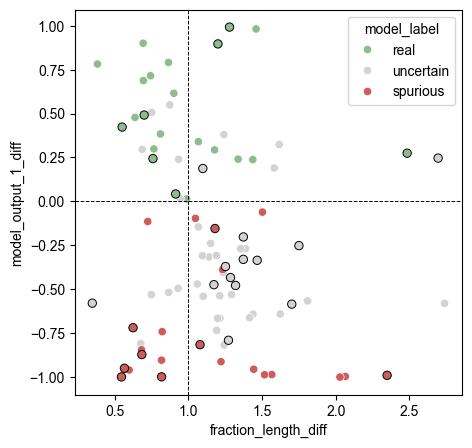

In [360]:
def figure(results_df:pd.DataFrame, diff_label_only:bool=True):

    fig, ax = plt.subplots(figsize=(5, 5))

    n_extensions = results_df.extension.sum()
    n_truncations = results_df.truncation.sum()

    palette = {'spurious':'indianred', 'uncertain':'lightgray', 'real':'darkseagreen'}
    figure_df = results_df[results_df.nt_length_diff != 0].copy()
    figure_df['nt_length'] = (figure_df.top_hit_stop - figure_df.top_hit_start)
    figure_df['fraction_length_diff'] = (figure_df.nt_length + figure_df.nt_length_diff) / figure_df.nt_length
    figure_df = figure_df.sort_values('model_output_0')

    if diff_label_only:
        figure_df = figure_df[figure_df.model_label != figure_df.top_hit_model_label].copy() # Filter for cases where the model label actually changes. 

    sns.scatterplot(figure_df[is_top_hit_hypothetical(figure_df)], y='model_output_1_diff', x='fraction_length_diff', hue='model_label', palette=palette)
    sns.scatterplot(figure_df[~is_top_hit_hypothetical(figure_df)], y='model_output_1_diff', x='fraction_length_diff', hue='model_label', palette=palette, edgecolor='black', lw=0.7, legend=False)

    ax.axvline(x=1, ls='--', color='black', lw=0.7)
    ax.axhline(y=0, ls='--', color='black', lw=0.7)

    print('figure: Num. extensions with positive shift:', ((figure_df.model_output_1_diff > 0) & figure_df.extension).sum(), f'({get_percent(((figure_df.model_output_1_diff > 0) & figure_df.extension).sum(), n_extensions)})')
    print('figure: Num. extensions with negative shift:', ((figure_df.model_output_1_diff < 0) & figure_df.extension).sum(), f'({get_percent(((figure_df.model_output_1_diff < 0) & figure_df.extension).sum(), n_extensions)})')
    print('figure: Num. truncations with positive shift:', ((figure_df.model_output_1_diff > 0) & figure_df.truncation).sum(), f'({get_percent(((figure_df.model_output_1_diff > 0) & figure_df.truncation).sum(), n_truncations)})')
    print('figure: Num. truncations with negative shift:', ((figure_df.model_output_1_diff < 0) & figure_df.truncation).sum(), f'({get_percent(((figure_df.model_output_1_diff < 0) & figure_df.truncation).sum(), n_truncations)})')
    # ax.set_xlim(xmax=3)
    plt.show()

figure(results_df)

# Based on this, it seems as though extensions are more likely to shift model output from real towards spurious, or at least uncertain. 
# Somewhat surprising, but possibly due to sensitivity to overlap introduced by the extension. 

figure: Num. conflicting extensions: 731 (22.44%)
figure: Num. conflicting extensions where conflict can be eliminated: 510 (15.66%)
figure: Num. conflicting extensions with negative label change: 17 (2.33%)
figure: Num. non-conflicting extensions with negative label change: 26 (1.03%)


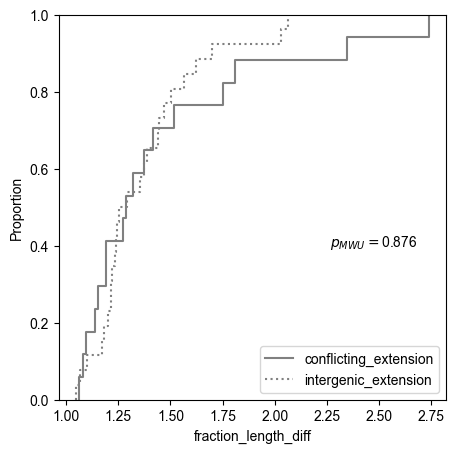

In [361]:
# If the model is sensitive to conflict with other genetic elements, we would expect an extension which introduces a conflict to be more likely
# to result in spurious misclassification. However, severity of the conflict will be confounded with extension length, so we control for this by comparing the extension length
# distributions. We would expect that extensions which introduce a conflict will be shorter than those which extend into intergenic regions if the model is sensitive to conflict.

has_overlap = lambda df : ~ ((df.query_stop < df.subject_start) | (df.query_start > df.subject_stop))
get_overlap_length = lambda df : np.min([df.query_stop.values, df.subject_stop.values], axis=0) - np.max([df.query_start.values, df.subject_start.values], axis=0) + 1

def figure(results_df:pd.DataFrame):

    figure_df = results_df[results_df.extension].drop(columns=['same_strand', 'overlap_length'])
    # figure_df = results_df[results_df.extension & (results_df.model_output_1_diff < 0)].drop(columns=['same_strand', 'overlap_length'])
    figure_df['query_start'], figure_df['query_stop'] = figure_df.top_hit_start, figure_df.top_hit_stop 
    figure_df['nt_length'] = (figure_df.top_hit_stop - figure_df.top_hit_start)
    figure_df['fraction_length_diff'] = (figure_df.nt_length + figure_df.nt_length_diff) / figure_df.nt_length
    
    # Add any potential conflicts from the all_hits.csv file. 
    all_hits_df = pd.read_csv('../data/results/results-2/all_hits.csv', index_col=0)
    all_hits_df = all_hits_df[all_hits_df.query_id.isin(df.index)].copy()
    all_hits_df = all_hits_df[all_hits_df.phase != 0].sort_values('overlap_length', ascending=False).drop_duplicates('query_id')
    all_hits_df = all_hits_df[['query_id', 'subject_id', 'subject_product', 'overlap_length', 'same_strand', 'subject_start', 'subject_stop', 'subject_feature']].copy()
    figure_df = figure_df.merge(all_hits_df, left_on='query_id', right_on='query_id', how='left') # Merge, preserving the order of the original DataFrame.
    figure_df['subject_start'], figure_df['subject_stop'], figure_df['overlap_length'] = figure_df.subject_start.fillna(0), figure_df.subject_stop.fillna(0), figure_df.overlap_length.fillna(0)

    # df['subject_feature'] = np.where(df.subject_feature.isnull(), 'none', df.subject_feature)
    # df['subject_product'] = np.where(df.subject_product.isnull(), 'none', df.subject_product)


    figure_df['adjusted_overlap_length'] = np.where(has_overlap(figure_df), get_overlap_length(figure_df), 0)
    figure_df['conflicting_extension'] = figure_df.adjusted_overlap_length < figure_df.overlap_length # If the overlap length is reduced by boundary adjustment, it is a conflicting extension. 
    n_conflicting_extensions = figure_df.conflicting_extension.sum()
    n_intergenic_extensions = (~figure_df.conflicting_extension).sum()

    print('figure: Num. conflicting extensions:', n_conflicting_extensions, f'({get_percent(n_conflicting_extensions, len(figure_df))})')
    print('figure: Num. conflicting extensions where conflict can be eliminated:', (figure_df.conflicting_extension & (figure_df.adjusted_overlap_length == 0)).sum(), f'({get_percent((figure_df.conflicting_extension & (figure_df.adjusted_overlap_length == 0)).sum(), len(figure_df))})')
    # mask = (np.abs(figure_df.model_output_1_diff) > 0) & (figure_df.model_label == figure_df.top_hit_model_label)
    mask = (figure_df.model_output_1_diff < 0) & (figure_df.model_label != figure_df.top_hit_model_label)
    figure_df = figure_df[mask].copy()
    print('figure: Num. conflicting extensions with negative label change:', figure_df.conflicting_extension.sum(), f'({get_percent(figure_df.conflicting_extension.sum(), n_conflicting_extensions)})')
    print('figure: Num. non-conflicting extensions with negative label change:', (~figure_df.conflicting_extension).sum(), f'({get_percent((~figure_df.conflicting_extension).sum(), n_intergenic_extensions)})')

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.ecdfplot(figure_df[figure_df.conflicting_extension], x='fraction_length_diff', color='gray', label='conflicting_extension')
    sns.ecdfplot(figure_df[~figure_df.conflicting_extension], x='fraction_length_diff', color='gray', ls=':', label='intergenic_extension')
    ax.legend()

    p = get_mann_whitney_p_value(figure_df[figure_df.conflicting_extension].fraction_length_diff, figure_df[~figure_df.conflicting_extension].fraction_length_diff, n_permutations=1000)

    text = '$p_{MWU}=$' + str(np.round(p, 3))
    ax.text(0.7, 0.4, text, transform=ax.transAxes)

    plt.show()

figure(results_df)


In [362]:

# Is the apparent sensitivity to 5' extensions possibly related to the severity allowed by extensions over truncations?
# Extensions have no upper bound, unlike truncations, and perhaps extensions tend to be generally longer than truncations. 
# In this case, it is possible that the sensitivity is not related to the nature of the boundary difference, but the severity.

# If this is the case, then the assumption is that more severe boundary changes are more likely to result in a negative shift 
# than a positive shift which seems plausible. 

# Comparing magnitude of extension versus truncation might be like comparing apples to oranges. Probably not worth doing.

# def figure(results_df):
#     figure_df = results_df.copy()
#     figure_df['nt_length_diff'] = np.abs(results_df.nt_length_diff)
#     figure_df['length_diff_fraction'] = figure_df.nt_length_diff / figure_df.nt_length
#     figure_df['different_model_label'] = figure_df.model_label != figure_df.top_hit_model_label
#     figure_df['negative_shift'] = figure_df.different_model_label & (figure_df.model_output_1_diff < 0)
#     figure_df['positive_shift'] = figure_df.different_model_label & (figure_df.model_output_1_diff > 0)

#     fig, ax = plt.subplots(figsize=(5, 5))
#     # sns.ecdfplot(figure_df[figure_df.extension & figure_df.positive_shift], x='length_diff_fraction', color='gray')
#     # sns.ecdfplot(figure_df[figure_df.truncation & figure_df.positive_shift], x='length_diff_fraction', color='gray', ls=':')
#     sns.ecdfplot(figure_df[figure_df.extension & figure_df.different_model_label], x='length_diff_fraction', color='gray')
#     sns.ecdfplot(figure_df[figure_df.truncation & figure_df.different_model_label], x='length_diff_fraction', color='gray', ls=':')
#     # sns.ecdfplot(figure_df[figure_df.extension & figure_df.negative_shift], x='length_diff_fraction', color='gray')
#     # sns.ecdfplot(figure_df[figure_df.truncation & figure_df.negative_shift], x='length_diff_fraction', color='gray', ls=':')

#     ax.axvline(x=0.3, lw=0.7, color='black', ls='--')
#     text = get_text('extension', (figure_df.extension & figure_df.negative_shift & (figure_df.length_diff_fraction < 0.3)).sum(),(figure_df.extension & figure_df.different_model_label & (figure_df.length_diff_fraction < 0.3)).sum())
#     text += get_text('truncation', (figure_df.truncation & figure_df.negative_shift & (figure_df.length_diff_fraction < 0.3)).sum(),(figure_df.truncation & figure_df.different_model_label & (figure_df.length_diff_fraction < 0.3)).sum())
#     ax.text(0.5, 0.5, text, transform=ax.transAxes)
#     # sns.ecdfplot(figure_df[figure_df.extension & figure_df.negative_shift], x='length_diff_fraction')
#     # sns.ecdfplot(figure_df[figure_df.truncation & figure_df.negative_shift], x='length_diff_fraction')

#     # sns.ecdfplot(figure_df[figure_df.extension & ~figure_df.different_model_label], x='length_diff_fraction', ls=':')
#     # sns.ecdfplot(figure_df[figure_df.truncation & ~figure_df.different_model_label], x='length_diff_fraction', ls=':')
#     ax.set_xlim(xmax=1, xmin=0)
#     plt.show()